# Key Takeaways

Chapter 7 of Eryk Lewinson's [*Python for Finance Cookbook*](https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518) covers portfolios returns and optimization.

***The key takeaways from this notebook are:***

1. Evaluating $\frac{1}{n}$ portfolios (i.e., the equal-weighted portfolio)
1. Using SciPy's optimizer to find the efficient frontier
1. Using SciPy's optimizer to achieve any objective

***Note:*** Indented block quotes are from Lewinson, and section numbers differ from Lewinson because we will not discuss every topic.

I love the topics in Lewinson.
However, I will simplify and streamline his code, where possible.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

# Evaluating the performance of a basic 1/n portfolio

> We begin with inspecting the most basic asset allocation strategy: the 1/n portfolio. The idea is to assign equal weights to all the considered assets, thus diversifying the portfolio. As simple as that might sound, DeMiguel, Garlappi, and Uppal (2007) show that it can be difficult to beat the performance of the 1/n portfolio by using more advanced asset allocation strategies.
>
> The goal of the recipe is to show how to create a 1/n portfolio, calculate its returns, and then use a Python library called pyfolio to quickly obtain all relevant portfolio evaluation metrics in the form of a tear sheet. Historically, a tear sheet is a concise, usually one-page, document, summarizing important information about public companies.

We will not use `pyfolio`, which appears to be abandoned.

We will follow Lewinson's structure, although I prefer to download all data.
These data are small (kilobytes instead of megabytes or gigabytes), so we might as well download all data then subset when necessary.

In [4]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT', 'TWTR']
START_DATE = '2017-01-01'
END_DATE = '2018-12-31'

In [5]:
df = yf.download(tickers=RISKY_ASSETS, session=session)

[*********************100%***********************]  4 of 4 completed


In [6]:
returns = df.loc[START_DATE:END_DATE, 'Adj Close'].pct_change().dropna()

Before we do any math, let us try to make $\frac{1}{n}$ portfolios "by hand".

In [7]:
p1 = 0.25*returns['AAPL'] + 0.25*returns['IBM'] + 0.25*returns['MSFT'] + 0.25*returns['TWTR']

In [8]:
p2 = 0.25 * returns.sum(axis=1)

In [9]:
np.allclose(p1, p2)

True

In [10]:
p3 = returns.mean(axis=1)

In [11]:
np.allclose(p1, p3)

True

***Note that when we do this type of calculation, we rebalance at the same frequency as the returns data.***
If we have daily data, rebalance daily.
If we have monthly data, we rebalance monthly, and so on.

I prefer to define the portfolio weights *after* we calculate returns.
This approach makes sure that we define the portfolio weights based on available data (i.e., the data we received, instead of the data we asked for).

In [12]:
returns.shape

(501, 4)

In [13]:
portfolio_weights = np.ones(returns.shape[1]) / returns.shape[1]

In [14]:
portfolio_weights

array([0.25, 0.25, 0.25, 0.25])

I prefer a different notation to calculate returns.
The following notation is more compact than Lewinson's notation and generates the same output.
$$R_P = \omega^T R,$$ where $R_P$ is a vector of portfolio returns, $\omega$ is a vector of portfolio weights, and $R$ is a matrix of individual stock or asset returns.

In [15]:
portfolio_returns = returns.dot(portfolio_weights)

In [16]:
np.allclose(p1, portfolio_returns)

True

Here are some silly data to help understand the `.dot()` method.

In [17]:
silly = pd.DataFrame(np.arange(8).reshape(2, 4))

In [18]:
silly

,0,1,2,3
0,0,1,2,3
1,4,5,6,7


In [19]:
silly.dot(portfolio_weights)

0   1.5000
1   5.5000
dtype: float64

In [20]:
silly_weights = np.array([1, 0, 0, 0])

In [21]:
silly.dot(silly_weights)

0    0
1    4
dtype: int64

---

***Practice:***
Write functions for the following performance measures that Lewinson discusses:

> - Sharpe ratio: One of the most popular performance evaluation metrics, it measures the excess return (over the risk-free rate) per unit of standard deviation. When no risk-free rate is provided, the default assumption is that it is equal to 0%. The greater the Sharpe ratio, the better the portfolio's risk-adjusted performance.
> - Max drawdown: A metric of the downside risk of a portfolio, it measures the largest peak-to-valley loss (expressed as a percentage) during the course of the investment. The lower the maximum drawdown, the better.
> - Calmar ratio: The ratio is defined as the average annual compounded rate of return divided by the maximum drawdown for that same time period. The higher the ratio, the better.
> - Stability: Measured as the R-squared of a linear fit to the cumulative log returns. In practice, this means regressing a range of integers (serving as the time index) on cumulative log returns.
> - Omega ratio: The probability-weighted ratio of gains over losses for a determined return target threshold (default set to 0). Its main advantage over the Sharpe ratio is that the Omega ratio—by construction—considers all moments of the returns distribution, while the former only considers the first two (mean and variance).
> - Sortino ratio: A modified version of the Sharpe ratio, where the standard deviation in the denominator is replaced with downside deviation.
> - Skew: Skewness measures the degree of asymmetry, that is, how much is the given distribution (here, of portfolio returns) more skewed than the Normal distribution. Negative skewness (left-skewed distributions) means  that large negative returns occur more frequently than large positive ones.
> - Kurtosis: Measures extreme values in either of the tails. Distributions with large kurtosis exhibit tail data exceeding the tails of the Gaussian distribution, meaning that large and small returns occur more frequently.
> - Tail ratio: The ratio (absolute) between the 95th and 5th percentile of the daily returns. A tail ratio of ~0.8 means that losses are ~1.25 times as bad as profits.
> - Daily value at risk: Calculated as $\mu - 2\sigma$, where $\mu$ is the average portfolio return over the period, and $\sigma$ the corresponding standard deviation.

Here are some tips:

1. Write functions that return decimal returns
1. For performance measures with benchmarks or targets, set the default to the risk-free rate of return from Ken French
1. Call these functions the lower-case version of the entry name with underscores instead of spaces

Also add:

1. Total return
1. Annual geometric mean return
1. Annual volatility

In [22]:
ff_all = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900', session=session)
ff = ff_all[0] / 100

In [23]:
def sharpe_ratio(ri, tgt):
    ri_tgt = (ri - tgt).dropna()
    return np.sqrt(252) * ri_tgt.mean() / ri_tgt.std()

In [24]:
def drawdown(ri):
    implied_price = (1 + ri).cumprod()
    return implied_price / implied_price.cummax() - 1

In [25]:
def max_drawdown(ri):
    return drawdown(ri).min() # use .min() because drawdown() is negative

***Note:*** Above we define maximum drawdown in terms of returns, which removes concerns about price drops due to either dividends or splits.
We will get very similar results (if not identical results) if we define maximum drawdown in terms of prices. 

In [26]:
max_drawdown(returns['AAPL'])

-0.3650953675219797

In [27]:
_ = df.loc[START_DATE:END_DATE, ('Adj Close', 'AAPL')]
_.div(_.cummax()).sub(1).min()

-0.36509536752198

In [28]:
_ = df.loc[START_DATE:END_DATE, ('Close', 'AAPL')]
_.div(_.cummax()).sub(1).min()

-0.36730298100985337

In [29]:
def cagr(ri):
    T = ri.shape[0]
    return (1 + ri).prod() ** (252/T) - 1

In [30]:
def calmar_ratio(ri):
    return cagr(ri) / (-1 * max_drawdown(ri))

In [31]:
def stability(ri):
    cumlogri = np.log(1 + ri).cumsum()
    time = np.arange(cumlogri.shape[0])
    df = pd.DataFrame({'cumlogri': cumlogri, 'time': time})
    import statsmodels.formula.api as smf
    fit = smf.ols(formula='cumlogri ~ time', data=df).fit()
    return fit.rsquared

In [32]:
def sortino_ratio(ri, tgt):
    ri_tgt = (ri - tgt).dropna()
    ri_tgt_downside = ri_tgt.loc[ri_tgt < 0]
    return np.sqrt(252) * ri_tgt.mean() / ri_tgt_downside.std()

In [33]:
def tail_ratio(ri):
    return np.abs(ri.quantile(0.95) / ri.quantile(0.05))

In [34]:
def daily_var(ri):
    return ri.mean() - 2 * ri.std()

In [35]:
def ann_std(ri):
    return np.sqrt(252) * ri.std()

In [36]:
def total_return(ri):
    return (1 + ri).prod() - 1

***Practice:***
Write a `tear_sheet()` function that tabulates average annual returns, cumulative returns, annual volatility, and the performance measures in the previous practice.

In [37]:
def tear_sheet(ri, tgt):
    name = ri.name
    begin = ri.index[0].strftime('%Y-%m-%d')
    end = ri.index[-1].strftime('%Y-%m-%d')

    df = pd.Series({
        'Name': name,
        'Begin': begin,
        'End': end,
        'Total Return (%)': 100 * total_return(ri=ri),
        'CAGR (%)': 100 * cagr(ri=ri),
        'Annual Volatility (%)': 100 * ann_std(ri=ri),
        'Sharpe Ratio': sharpe_ratio(ri=ri, tgt=tgt),
        'Max Drawdown (%)': 100 * max_drawdown(ri=ri),
        'Calmar Ratio': calmar_ratio(ri=ri),
        'Stability': stability(ri=ri),
        'Sortino Ratio': sortino_ratio(ri=ri, tgt=tgt),
        'Skew': ri.skew(),
        'Kurtosis': ri.kurt(),
        'Tail Ratio': tail_ratio(ri=ri),
        'Daily VaR (%)': 100 * daily_var(ri=ri),
    }).to_frame(name='Value')
    df.index.name = 'Performance Measure'
    
    return df

In [38]:
tear_sheet(ri=returns['AAPL'], tgt=ff['RF'])

,Value
Performance Measure,
Name,AAPL
Begin,2017-01-04
End,2018-12-31
Total Return (%),40.0628
CAGR (%),18.4676
Annual Volatility (%),23.8711
Sharpe Ratio,0.7743
Max Drawdown (%),-36.5095
Calmar Ratio,0.5058


---

# Finding the Efficient Frontier using Monte Carlo simulations

> According to the Modern Portfolio Theory, the Efficient Frontier is a set of optimal portfolios in the risk-return spectrum. This means that the portfolios on the frontier:
> 
> - Offer the highest expected return for a given level of risk
> - Offer the lowest level of risk for a given level of expected returns
> 
> All portfolios located under the Efficient Frontier curve are considered sub-optimal, so it is always better to choose the ones on the frontier instead.
> 
> In this recipe, we show how to find the Efficient Frontier using Monte Carlo simulations. We build thousands of portfolios, using randomly assigned weights, and visualize the results. To do so, we use the returns of four US tech companies from 2018.

We will skip Lewinson's Monte Carlo simulation of the efficient frontier.
For some students, this simulation is enlightening.
However, for many students, it creates bad habits.
Therefore, we will jump right to using the optimizer to find the efficient frontier.

# First, a crash course in scipy's minimize() function

The `sco.minimize()` function iteratively finds the input array `x` that minimizes the output of function `fun`.
We pass our first guess for the input array `x` to the argument `x0=`.
We pass additional arguments for the function `fun` as a tuple to the argument `args=`.
We pass the lower and upper bounds on `x` as a tuple of tuples to the argument `bounds=`.
We contrain our results with a tuple of dictionaries of functions to the argument`contraints=`.

Here is a simple example that minimizes the `quadratic()` function $y = (x - a)^2$ where $a=5$.

In [39]:
import scipy.optimize as sco

In [40]:
def quadratic(x, a=5):
    return (x - a) ** 2

Without bounds, we find the minimum output of `quadratic()` occurs at $x=5$.

In [41]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001])
)

      fun: 2.0392713450495178e-16
 hess_inv: array([[0.5]])
      jac: array([-0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([5.])

The minimum output of `quadratic()` occurs at $x=6$ if we bound `x` between 6 and 10 (i.e., $6 \leq x \leq 10$).

In [42]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    bounds=((6, 10),)
)

      fun: array([1.])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([6.])

Next we will learn about constraints.

# Finding the Efficient Frontier using optimization with scipy

> In the previous recipe, Finding the Efficient Frontier using Monte Carlo simulations, we used a brute-force approach based on Monte Carlo simulations to visualize the Efficient Frontier. In this recipe, we use a more refined method to determine the frontier.
> 
> From its definition, the Efficient Frontier is formed by a set of portfolios offering the highest expected portfolio return for a certain volatility, or offering the lowest risk (volatility) for a certain level of expected returns. We can leverage this fact, and use it in numerical optimization. The goal of optimization is to find the best (optimal) value of the objective function by adjusting the target variables and taking into account some boundaries and constraints (which have an impact on the target variables). In this case, the objective function is a function returning portfolio volatility, and the target variables are portfolio weights.
> 
> Mathematically, the problem can be expressed as: $$\min \omega^T \Sigma \omega$$ s.t. $$\omega^T \textbf{1} = 1$$ $$\omega \geq 0$$ $$\omega^T \mu = \mu_P$$
>
> Here, $\omega$ is a vector of weights, $\Sigma$ is the covariance matrix, $\mu$ is a vector of returns, $\mu_P$ and is the expected portfolio return.
> 
> We iterate the optimization routine used for finding the optimal portfolio weights over a range of expected portfolio returns, and this results in the Efficient Frontier.

We optimize our portfolios (i.e., minimize portfolio variance subject to contraints) with SciPy's optimize module.

We will skip Lewinson's helper functions because they require calculating new $\mu$ (mean return vectors) and $\Sigma$ (variance-covariance matrices) for every sample.
Calculating $\mu$ and $\Sigma$ once per sample then using his helper functions is more computationally efficient than the approach we will use below.
However, the time saved is very, very small on a modern computer (typically milliseconds), and managing samples, mean return vectors, variance-covariance matrices, and helper functions complicates these calculations.

Instead we will:

1. Calculate portfolio returns ($\mu_P$ or $R_P$) as we did above (`returns.dot(weights)`)
1. Caclulate anything we want to minimize by calculating it directly from portfolio returns

For example, if we want to minimize volatility, we can use the `.std()` method on the series of portfolio returns `returns.dot(weights)`.
If we want to *maximize* the Sharpe Ratio, we have to minimize negative one times the Sharpe Ratio because optimizers are designed to minimize only.

In [43]:
res_mv = sco.minimize(
    fun=lambda x: np.sqrt(252) * returns.dot(x).std(), # function we want to minimize the output of
    x0=np.ones(returns.shape[1]) / returns.shape[1], # first set of portfolio weights
    bounds=tuple((0,1) for c in returns.columns), # bounds for each portfolio weight
    constraints=(
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1} # we want this lambda function to evaluate to 0
    )
)
assert res_mv['success'] # we want to make sure sco.minimize() succeeded

In [44]:
res_mv

     fun: 0.1767745046514236
     jac: array([0.1768, 0.1767, 0.1769, 0.1776])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.2571, 0.5174, 0.218 , 0.0075])

What are the attributes of this minimum variance portfolio?

In [45]:
def print_port_res(w, title, df=returns):
    print(
        title,
        len(title) * '=',
        '',
        'Performance',
        '-----------',
        'Return:       {:0.4f}'.format(252 * df.dot(w).mean()),
        'Volatility:   {:0.4f}'.format(np.sqrt(252) * df.dot(w).std()),
        'Sharpe Ratio: {:0.4f}'.format(sharpe_ratio(ri=df.dot(w), tgt=ff['RF'])),
        '',
        sep='\n'
    )

    print('Weights', '-------', sep='\n')
    for i, j in zip(df.columns, w):
        print((i + ':').ljust(14) + '{:0.4f}'.format(j))


In [46]:
print_port_res(res_mv['x'], 'Minimum Variance Portfolio')

Minimum Variance Portfolio

Performance
-----------
Return:       0.0490
Volatility:   0.1768
Sharpe Ratio: 0.2031

Weights
-------
AAPL:         0.2571
IBM:          0.5174
MSFT:         0.2180
TWTR:         0.0075


Here is an equivalent solution that uses a simple helper function.
This helper is simpler than Lewinson's because it does not require a new return mean array and a new variance-covariance matrix for every sample.
Instead, we pass a series of portfolio returns re-calculate the means and variances every iteration, which is only slightly slower.

In [47]:
def port_std(w, rs):
    return np.sqrt(252) * rs.dot(w).std()

In [48]:
res = sco.minimize(
    fun=port_std, # we want to minimize portfolio volatility
    x0=np.ones(returns.shape[1]) / returns.shape[1], # x0 contains our first guess at portfolio weights
    args=(returns, ), # args provides additional argument to the function we will minimize
    bounds=((0, 1), (0, 1), (0, 1), (0, 1)), # bounds limits the search space for portfolio weights
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # "eq" constraints are driven to zero
    )
)
assert res['success']

In [49]:
print_port_res(res['x'], 'Minimum Variance Portfolio (Found with Helper Function)')

Minimum Variance Portfolio (Found with Helper Function)

Performance
-----------
Return:       0.0490
Volatility:   0.1768
Sharpe Ratio: 0.2031

Weights
-------
AAPL:         0.2571
IBM:          0.5174
MSFT:         0.2180
TWTR:         0.0075


---

***Practice:***
Map the efficient frontier.
Note that you must constrain returns to some target.

***Tips:*** 
We will minimize portfolio volatility subject to target portfolio return constraint.
So, next the `sco.minimize()` function call inside a loop over target returns.

In [50]:
252 * returns.mean()

AAPL    0.1980
IBM    -0.1313
MSFT    0.2888
TWTR    0.4086
dtype: float64

In [51]:
tgt_returns = np.linspace(
    start=(252 * returns.mean()).min(), 
    stop=(252 * returns.mean()).max(), 
    num=50
)

In [52]:
efficient_frontier = pd.DataFrame(
    columns=['std', 'tgt_return'], 
    index=np.arange(len(tgt_returns))
)

In [53]:
efficient_frontier.head()

,std,tgt_return
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [54]:
i = 0 # create row counter (unecessary with .iterrows() solutions)
for tgt in tgt_returns: # we could also add tgt_returns to efficient_frontier and use efficient_frontier.iter
    res = sco.minimize(
        fun=port_std, # we want to minimize portfolio volatility
        x0=np.ones(returns.shape[1]) / returns.shape[1], # x0 contains our first guess at portfolio weights
        args=(returns, ), # args provides additional argument to the function we will minimize
        bounds=((0, 1), (0, 1), (0, 1), (0, 1)), # bounds limits the search space for portfolio weights
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # "eq" constraints are driven to zero
            {'type': 'eq', 'fun': lambda x: 252 * returns.dot(x).mean() - tgt} # "eq" constraints are driven to zero
        )
    )
    assert res['success']
    
    efficient_frontier.loc[i, 'std'] = res['fun']
    efficient_frontier.loc[i, 'tgt_return'] = tgt
    i += 1 # increment row counter (unecessary with .iterrows() solutions)

In [55]:
efficient_frontier.head()

,std,tgt_return
0,0.2064,-0.1313
1,0.2024,-0.1202
2,0.1987,-0.1092
3,0.1953,-0.0982
4,0.1922,-0.0872


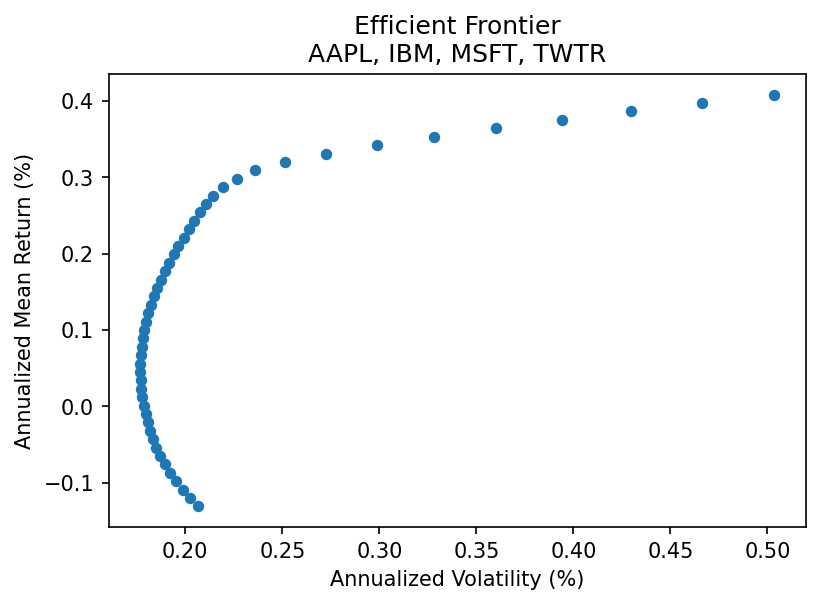

In [56]:
efficient_frontier.plot(kind='scatter', x='std', y='tgt_return')
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title('Efficient Frontier' + '\n' + ', '.join(returns.columns))
plt.show()

***Practice:***
Find the portfolio with the maximum Sharpe Ratio.
Note that `sco.minimize()` finds *minimums*, so you need to minimize the *negative* Sharpe Ratio.

In [57]:
def port_sr_neg(w, df, tgt):
    return -1 * sharpe_ratio(ri=df.dot(w), tgt=tgt)

In [58]:
res_msr = sco.minimize(
    fun=port_sr_neg,
    args=(returns, ff['RF']),
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    bounds=((0, 1), (0, 1), (0, 1), (0, 1)),
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # eq constraints must eval. to 0
    )
)
assert res_msr['success']

In [59]:
print_port_res(w=res_msr['x'], title='Maximum Sharpe Ratio Portfolio (Long-Only Weights)')

Maximum Sharpe Ratio Portfolio (Long-Only Weights)

Performance
-----------
Return:       0.3038
Volatility:   0.2303
Sharpe Ratio: 1.2623

Weights
-------
AAPL:         0.0000
IBM:          0.0000
MSFT:         0.8747
TWTR:         0.1253


We can combine the stock returns and efficient frontier with a little work.

/home/richard/anaconda3/envs/fina-4380/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


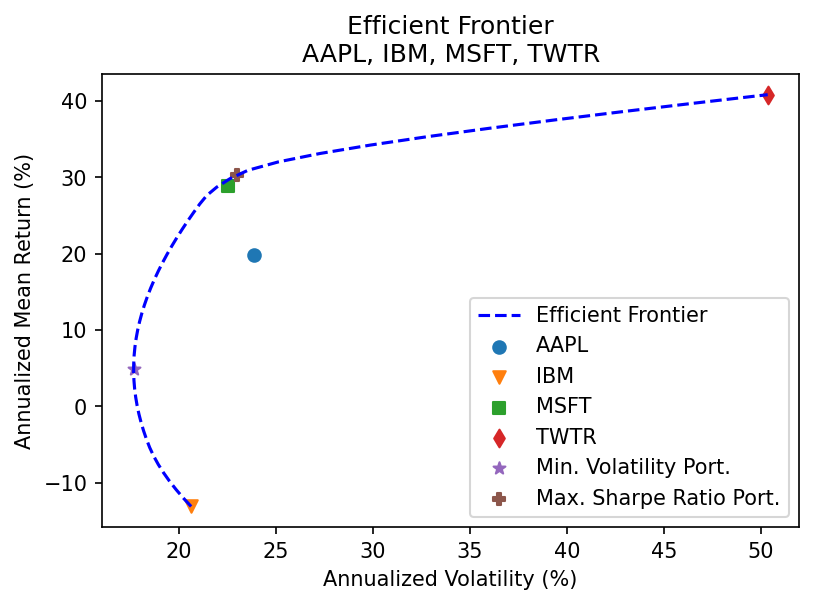

In [60]:
markers = {
    'AAPL': 'o', 
    'IBM': 'v', 
    'MSFT': 's', 
    'TWTR': 'd',
    'mv': '*',
    'msr': 'P'
}

labels = {
    'mv': 'Min. Volatility Port.',
    'msr': 'Max. Sharpe Ratio Port.',
    'std': 'Annualized Volatility (%)',
    'tgt_return': 'Annualized Mean Return (%)'
}

fig, ax = plt.subplots()

efficient_frontier.mul(100).plot(
    kind='line',
    style='b--',
    label='Efficient Frontier',
    x='std',
    y='tgt_return',
    ax=ax
)

for i in returns:
    ax.scatter(
        x=100 * np.sqrt(252) * returns[i].std(), 
        y=100 * 252 * returns[i].mean(), 
        marker=markers[i], 
        label=i
    )


    
# min. variance portfolio
ax.scatter(
    x=100 * np.sqrt(252) * returns.dot(res_mv['x']).std(), 
    y=100 * 252 * returns.dot(res_mv['x']).mean(), 
    marker=markers['mv'], 
    label=labels['mv']
)

    
# max. sharpe ratio portfolio
ax.scatter(
    x=100 * np.sqrt(252) * returns.dot(res_msr['x']).std(), 
    y=100 * 252 * returns.dot(res_msr['x']).mean(), 
    marker=markers['msr'], 
    label=labels['msr']
)
    
plt.legend()

ax.set(
    xlabel=labels['std'], 
    ylabel=labels['tgt_return'], 
    title='Efficient Frontier' + '\n' + ', '.join(returns.columns)
)

plt.show()

***Practice:***
What is the *out-of-sample* performance of this maximum Sharpe Ratio portfolio?
For example, what is the Sharpe Ratio of this portfolio from 2019 through today?
How does this compare to the Sharpe Ratio of the $1/N$ portfolio?

Notice how much the Sharpe Ratio falls for the Maximum Sharpe Ratio Portfolio Out-of-Sample.

In [61]:
print_port_res(
    w=res['x'], 
    title='Maximum Sharpe Ratio Portfolio Out-of-Sample',
    df=df.loc['2019':, 'Adj Close'].pct_change()
)

Maximum Sharpe Ratio Portfolio Out-of-Sample

Performance
-----------
Return:       0.2553
Volatility:   0.5208
Sharpe Ratio: 0.3907

Weights
-------
AAPL:         0.0000
IBM:          0.0000
MSFT:         0.0000
TWTR:         1.0000


The $\frac{1}{n}$ portfolio has (essentially) the same performance

In [62]:
print_port_res(
    w=np.ones(returns.shape[1]) / returns.shape[1], 
    title='1/n Portfolio Out-of-Sample',
    df=df.loc['2019':, 'Adj Close'].pct_change()
)

1/n Portfolio Out-of-Sample

Performance
-----------
Return:       0.3076
Volatility:   0.2835
Sharpe Ratio: 0.9573

Weights
-------
AAPL:         0.2500
IBM:          0.2500
MSFT:         0.2500
TWTR:         0.2500


***Practice:***
Find the portfolio with the maximum Sharpe Ratio, but allow short positions up to 30% of the portfolio.
So for every one dollar invested, you can short one or more of these four stocks to finance another 30 cents.

In [63]:
res = sco.minimize(
    fun=port_sr_neg,
    args=(returns, ff['RF']),
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    bounds=((-0.3, 1.3), (-0.3, 1.3), (-0.3, 1.3), (-0.3, 1.3)),
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # eq constraints must eval. to 0
        {'type': 'ineq', 'fun': lambda x: x[x < 0].sum() + 0.3} # ineq constraints must eval. to >= 0
    )
)
assert res['success']

/home/richard/anaconda3/envs/fina-4380/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/richard/anaconda3/envs/fina-4380/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/richard/anaconda3/envs/fina-4380/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [64]:
res

     fun: -1.5210569535178415
     jac: array([0.1442, 0.7868, 0.1438, 0.1465])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.0782, -0.3   ,  1.1035,  0.1184])

---